# Visión computacional basada en redes neuronales artificiales

# Unidad 3: Clasificación de imágenes
## Clase 7: Introducción a la clasificación con redes neuronales


## 1. Configuración del ambiente

Para empezar a trabajar, vamos a instalar primero la librería ```wget```, que la vamos a necesitar para descargar archivos usando Python directamente.

In [ ]:
# instalamos la librería wget usando pip
!pip install wget

# probamos si se instaló bien importándola
import wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=4dab68abd8a71ccfe1a913f845fda23547eb5abec51a2a629f8e39a652bc6d20
  Stored in directory: /root/.cache/pip/wheels/01/46/3b/e29ffbe4ebe614ff224bad40fc6a5773a67a163251585a13a9
Successfully built wget


## 2. Un ejemplo de clasificación de imágenes con redes neuronales

En esta primera clase de clasificación con imágenes con redes neuronales, vamos a trabajar con una red preentrenada (no nos interesa cuál ni cómo funciona por ahora), a la que vamos a alimentar con datos y de la que vamos a analizar sus respuestas.


### 2.1. Imágenes de ImageNet

![](https://miro.medium.com/max/1400/1*v64BvvzbeJvhSen1X7IPNA.jpeg)

Vamos a operar con una red que se entrenó para clasificar imágenes del banco de datos [ImageNet](https://www.image-net.org/), que contiene más de 1 millón de imágenes etiquetadas en 1000 categorías diferentes. Cada categoría está asociada a un elemento diferente, y representada por un valor discreto entre 0 y 999. Para conocer qué número representa qué cosa, vamos a necesitar bajarnos un diccionario que nos traduzca de una cosa a la otra. Es lo que haremos en el bloque de código que les planteamos a continuación:

In [ ]:
# importamos las librerías para trabajar con rutas y remover archivos
from os import path, remove
# y esta librería adicional que nos permite mapear texto a diccionarios
import ast

# establecemos la URL donde está el diccionario en forma de archivo de texto
URL_CLASS_IDS = "https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt"
# determinamos el nombre del archivo que vamos a abrir
txt_classes_filename = "imagenet1000_clsidx_to_labels.txt"
# si el archivo no existe, lo descargamos con wget
if not path.exists(txt_classes_filename):
  file_name = wget.download(URL_CLASS_IDS)

# abrimos el archivo
with open(txt_classes_filename) as reader:
  # leemos su contenido
  contents = reader.read()
  # y lo mapeamos a un diccionario python
  image_net_labels = ast.literal_eval(contents)

# imprimimos por pantalla su contenido
print(image_net_labels)

{0: 'tench, Tinca tinca', 1: 'goldfish, Carassius auratus', 2: 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias', 3: 'tiger shark, Galeocerdo cuvieri', 4: 'hammerhead, hammerhead shark', 5: 'electric ray, crampfish, numbfish, torpedo', 6: 'stingray', 7: 'cock', 8: 'hen', 9: 'ostrich, Struthio camelus', 10: 'brambling, Fringilla montifringilla', 11: 'goldfinch, Carduelis carduelis', 12: 'house finch, linnet, Carpodacus mexicanus', 13: 'junco, snowbird', 14: 'indigo bunting, indigo finch, indigo bird, Passerina cyanea', 15: 'robin, American robin, Turdus migratorius', 16: 'bulbul', 17: 'jay', 18: 'magpie', 19: 'chickadee', 20: 'water ouzel, dipper', 21: 'kite', 22: 'bald eagle, American eagle, Haliaeetus leucocephalus', 23: 'vulture', 24: 'great grey owl, great gray owl, Strix nebulosa', 25: 'European fire salamander, Salamandra salamandra', 26: 'common newt, Triturus vulgaris', 27: 'eft', 28: 'spotted salamander, Ambystoma maculatum', 29: 'axolotl, mu

Si analizamos el contenido del diccionario, vamos a ver que está estructurado con pares de la forma ```(int, str)```, donde primero tenemos un número entero que representa a la clase y luego un string con diferentes nombres asociados a la clase.

Por ejemplo, la clase 0 representa ```"tench, Tinca tinca"```. [*Tench*](https://www.google.com/search?q=tench&rlz=1C5CHFA_enAR697AR697&sxsrf=ALiCzsbInqF-SlNZshV-FlNFJkz0sCIndw:1660587429471&source=lnms&tbm=isch&sa=X&ved=2ahUKEwi5_Oeeusn5AhUbs5UCHSvXA9kQ_AUoAXoECAIQAw&biw=2048&bih=1169&dpr=2) es un pez de agua dulce que en español se llama ["Tenca"](https://es.wikipedia.org/wiki/Tinca_tinca), y cuyo nombre científico es justamente *"Tinca tinca"*.

¿Hay solamente animales? No, para nada. Por ejemplo, la clase 593 corresponde a la [*harmonica*](https://www.google.com/search?q=harmonica&rlz=1C5CHFA_enAR697AR697&sxsrf=ALiCzsbYJeYjxcKF2HE0GD8qaUa6Zq4vOw:1660587723367&source=lnms&tbm=isch&sa=X&ved=2ahUKEwi1_Pmqu8n5AhU7kpUCHf6rDkYQ_AUoAXoECAEQAw&biw=2048&bih=1169&dpr=2), que también viene definida como "mouth organ", "harp" o "mouth harp". Es decir, para cada clase, tenemos varios sinónimos asociados o formas diferentes de referirse a ella, para evitar confusiones.

### 2.2. Preparar un modelo de clasificación en PyTorch

A continuación vamos a crear un modelo de clasificación en PyTorch. En lugar de definirlo componente a componente (como vamos a hacer más adelante), vamos a simplemente usar la API de PyTorch y "envolver" un modelo que ya está entrenado, y que vamos a bajar del paquete ```Torchvision``` de la librería.

Si recordamos de las clases anteriores, los modelos de deep learning se definen en PyTorch como objetos de la clase ```torch.nn.Module```, que nos brinda la interfaz necesaria para poder entrenarlos usando gradiente descendente y backpropagation sin necesidad de escribir derivadas raras.

Cuando vamos a definir nuestro modelo particular, tenemos que crear una clase nueva (en este caso la llamaremos ```DeepLearningClassificationModel```, que vamos a necesitar que herede de la clase ```torch.nn.Module``` para que tenga los mismos métodos y la misma funcionalidad.

Luego, vamos a necesitar definirle al menos dos métodos:

* El método ```__init__```, que es el constructor de la clase, en donde determinamos la arquitectura que va a tener la red neuronal. Como en nuestro caso vamos a trabajar con una red neuronal preentrenada, aquí solamente vamos a crear un atributo ```_model_ft``` y le vamos a asignar a él un modelo ```resnet18``` que vamos a descargar del paquete ```torchvision.models```. Además, vamos a agregar un atributo adicional, al que llamaremos ```_data_transforms```, que incluye una serie de transformaciones que originalmente se aplicaron para entrenar el modelo, y que ahora las vamos a necesitar usar siempre que querramos obtener una respuesta del modelo.

* El método ```forward()```, que es el que utilizaremos para obtener la predicción del modelo tanto en tiempo de entrenamiento como de test. Este método recibe como entrada una variable ```inputs```, que representa los tensores de entrada del modelo, y devolverá las salidas que nos interesa obtener. Internamente, lo único que haremos será alimentar al atributo ```_model_ft``` con ```inputs``` y aplicar la función de activación sobre sus salidas, para convertir los logits en probabilidades. Además, vamos a agregar unas líneas más que nos permiten identificar la clase con la probabilidad asociada más alta y su valor. En total, retornaremos 3 cosas: la probabilidad más alta, su clase asociada y la lista de todas las probabilidades.

Adicionalmente, nosotros vamos a agregar un método extra al que llamaremos ```preprocess```, y que, dada una imagen de PIL, aplica sobre ella todas las transformaciones asignadas al atributo ```_data_transforms```. Esto nos permite modelar dentro mismo de la clase las operaciones necesarias para dejar los datos listos, y así evitar problemas por no haberlo alimentado con los datos formateados de manera correcta.

In [ ]:
import torch
from torchvision import transforms
from torchvision.models import resnet18, ResNet18_Weights


class DeepLearningClassificationModel(torch.nn.Module):
  """
    Clase que representa un modelo de clasificación de imágenes, y que
    internamente     usa una ResNet18 pre-entrenada en ImageNet.

    Attributes
    ----------
    _model_ft : torchvision.modelsresnet18
        un modelo resnet18 pre-entrenado en ImageNet
    _data_transforms : torchvision.transforms.Compose
        un objeto Compose de torchvision con una composición de operaciones de
        transformación

    Methods
    -------
    forward(inputs)
        forward pass del modelo sobre inputs.
    preprocess(image)
        preprocesa una image image y la deja lista para procesar con el modelo.
    """

  def __init__(self, class_dictionary):
    """
       Parameters
       ----------
       class_dictionary : dict
           Diccionario que traduce los números de clase a su identificador
    """

    # siempre usamos super para inicializar un Module
    super().__init__()

    # creamos una arquitectura ResNet18, y la pedimos con los pesos de ImageNet
    self._model_ft = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
    # ponemos la red en modo evaluación (porque siempre la vamos a usar así)
    self._model_ft.eval()
    # asignamos las transformaciones que son necesarias para preprocesar
    # los datos de entrada de esta red
    self._data_transforms = ResNet18_Weights.IMAGENET1K_V1.transforms()
    # y también asignamos el diccionario
    self.class_dictionary = class_dictionary


  def forward(self, inputs):
    """Forward pass del modelo, que procesa las entradas y devuelve las salidas

       Parameters
       ----------
       inputs : torch.Tensor
           Un tensor de tamaño (N, C, H, W) con N = número de muestras por
           batch, C = número de canales de la imagen de entrada, H = altura de
           la imagen, y W = ancho de la imagen.

       Returns
       -------
       torch.Tensor
           Tensor de tamaño (N, 1000) con N = número de muestras por batch y
           1000 la cantidad de clases de ImageNet
    """

    # alimentamos el modelo con las entradas
    outputs = self._model_ft(inputs)

    return outputs


  def predict(self, inputs):
    """Hace un forward pass del modelo y además formatea las salidas

      Parameters
      ----------
      inputs : torch.Tensor
          Un tensor de tamaño (N, C, H, W) con N = número de muestras por
          batch, C = número de canales de la imagen de entrada, H = altura de
          la imagen, y W = ancho de la imagen.

      Returns
      -------
      int
          Clase que el modelo predijo como más probable
      float
          Probabilidad asociada a esa clase
      str
          Nombre de la clase más probable según el modelo
      torch.Tensor
          Tensor de tamaño (N, 1000) con N = número de muestras por batch y
          1000 la cantidad de clases de ImageNet
    """


    outputs = self.forward(inputs)
    # aplicamos softmax para convertirlas en probabilidades
    all_probabilities = torch.nn.functional.softmax(outputs, dim=1)
    # identificamos la clase más probable y su probabilidad asociada
    highest_prob, pred_class = torch.max(all_probabilities, dim=1)

    # mapeamos el tensor con la clase más probable a un entero
    pred_class = int(pred_class)
    # usamos el índice de la clase para identificar su nombre
    class_name = self.class_dictionary[int(pred_class)]
    # mapeamos el valor de probabilidad a un float
    highest_prob = float(highest_prob)

    # retornamos la clase, su probabilidad asociada, su nombre y el arreglo de
    # probabilidades que nos dio el modelo
    return pred_class, highest_prob, class_name, all_probabilities


  def preprocess(self, image, verbose = False):
    """Preprocesa una imgen y la devuelve lista para alimentar la red

      Parameters
      ----------
      image : PIL.Image
          Una imagen RGB de PIL
      verbose : bool
          Un booleano que te permite imprimir la imagen después de procesarla

      Returns
      -------
      torch.Tensor
          Un tensor de tamaño (N, C, H, W) con N = número de muestras por
          batch, C = número de canales de la imagen de entrada, H = altura de
          la imagen, y W = ancho de la imagen.
    """

    # aplicamos las transformaciones sobre la imagen
    tensor_image = self._data_transforms(image)

    # si verbose es True, mostramos la imagen
    if verbose:
      plt.imshow(tensor_image.permute(1, 2, 0))
      plt.show()

    # convertimos el tensor en un batch con un solo elemento
    tensor_image = tensor_image.unsqueeze(dim=0)

    return tensor_image

Con todo este código lo único que hicimos fue definir la clase con la que vamos a trabajar. El siguiente paso es crear un objeto de esta clase, para que podamos utilizarlo. Además, vamos a mover al modelo a la GPU, para que corra más rápidamente luego. Finalmente, lo vamos a imprimir para asegurarnos de que quedó creado correctamente.

In [ ]:
# creamos un objeto model de la clase DeepLearningClassificationModel
model = DeepLearningClassificationModel(class_dictionary = image_net_labels)
# y lo movemos a la gpu
model = model.cuda()

print(model)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 210MB/s]


DeepLearningClassificationModel(
  (_model_ft): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0

*Et voilà!* Ya tenemos nuestro modelo preentrenado, y listo para correrlo sobre las imágenes que querramos.

### 2.3. A clasificar imágenes!

Ya contamos con todos los componentes necesarios para poder clasificar cualquier imagen, con lo cual el próximo paso es empezar a hacerlo.

En este código de ejemplo, vamos a descargar una imagen (para empezar, la de Pomelo) y vamos a dejarla lista para que nuestro modelo la preprocese y luego la clasifique. Para ello, vamos a descargarla de internet usando ```wget```, convertirla en RGB (en caso de que justo sea una en escala de grises o que tenga un canal alpha de transparencia) y la vamos a imprimir por pantalla.

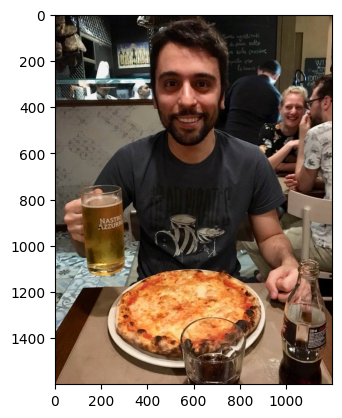

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

# por defecto, todas las imágenes van a llevar este nombre
example_filename = "image_example.png"
# si ya existía, la vamos a borrar para evitar que se nos llene la nube
# de pavadas
if path.exists(example_filename):
  remove(example_filename)

#link = "https://raw.githubusercontent.com/ignaciorlando/duia-cv-datasets/master/dog.png"  # pomelo (bulldog frances)
# otros ejemplos que vamos a trabajar:
#link = "https://cdn.divessi.com/cached/Wildlife_Tench_Shutterstock-Rostislav-Stefanek.jpg/600.jpg"
link = "https://github.com/ignaciorlando/ignaciorlando.github.io/raw/master/datasets/roma.jpeg" # nacho hambriento y sediendo en Roma
# bajamos la imagen
wget.download(link, example_filename)

# abrimos la imagen usando PIL
pil_image = Image.open(example_filename)
# le sacamos el canal alpha (si lo tiene)
pil_image = pil_image.convert("RGB")
# la mostramos por pantalla
plt.imshow(pil_image)
plt.show()

Hasta acá no hicimos nada muy loco. Lo próximo... bueno, lo próximo tampoco es muy loco, pero sí es necesario. Vamos primero a preprocesar la imagen, y luego a pasarla a la GPU, para que viva en el mismo lugar que la red neuronal.

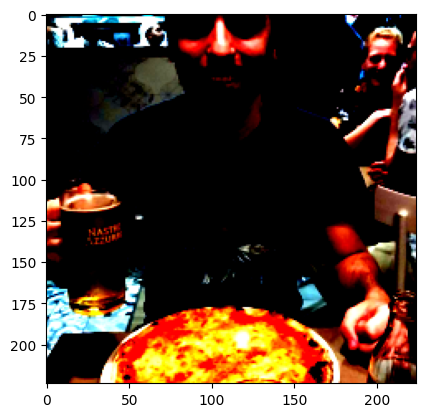

In [ ]:
# preprocesamos la imagen
tensor_image = model.preprocess(pil_image, verbose=True)
# la pasamos a cuda, para que esté en la GPU
tensor_image = tensor_image.cuda()

Y ahora sí, listxs para clasificar! El próximo código lo que hará es llamar al modelo que creamos, que a su vez llamará al método ```forward``` que codeamos nosotros, y que a su vez llamará a ```resnet18``` para clasificar la imagen, luego encontrará la clase más probable, su valor de probabilidad asociado, su nombre, y nos devolverá todas las probabilidades.

Van a ver que usamos un ```with torch.no_grad()``` al principio de todo. Con esta instrucción estamos diciéndole a PyTorch que no precalcule nada vinculado con los gradientes ni que reserve memoria, porque estamos en tiempo de test y la red acá no se entrena. Es importante que recuerden usar esto (además de poner el modelo en modo evaluación, pero lo vamos a ver más adelante) para evitar un consumo innecesario de memoria en tiempo de test.

Bueno, basta, probemos esto!

In [ ]:
# sin utilizar gradientes (porque estamos haciendo predicciones)...
with torch.no_grad():

  # alimentamos al modelo con esta imagen
  predicted_class, predicted_prob, class_name, all_probabilities = model.predict(tensor_image)

  print("ID de la clase: ", predicted_class)
  print("Nombre de la clase: ", class_name)
  print("Probabilidad: {:.4f}".format(predicted_prob))
  #print("All prbabilities: {}".format(all_probabilities))

ID de la clase:  118
Nombre de la clase:  Dungeness crab, Cancer magister
Probabilidad: 0.2643


Bueno, felicitaciones! Clasificaron su primera imagen con una red neuronal! Como verán, al haberla aplicado sobre la imagen de Pomelo, obtuvimos con un 73.66% de confianza que se trata de un bulldog francés, cuyo índice es el número 245. En la guía práctica tienen para jugar un poco con este modelo pre-entrenado y con otras imágenes, incluyendo una mía muy feliz con una pizza y una cerveza.

### 2.4. Clasificación top-k

A veces puede ocurrir que en una imagen haya más de un objeto destacable. En esos casos, ¿qué pasa si la red se ve tentada a elegir un elemento en particular en lugar de algún otro?

Bueno, ese tipo de problemas suele resolverse usando detección de objetos, en donde en lugar de asignarle una única clase a la imagen, identificamos "cajas" que envuelven a cada objeto, y a cada caja le asignamos una clase.

Pero en este caso, que estamos trabajando con clasificación, podemos aproximar una solución simplemente identificando las $K$ clases con mayor probabilidad. Esta estrategia se usa mucho por ejemplo para evaluar y comparar los modelos entrenados en ImageNet, contando como un acierto de la red para una imagen dada si entre las 5 clases de mayor probabilidad que encontró está la clase que originalmente estaba asociada a la imagen.

En el ejemplo de acá abajo les dejé preparado la predicción top-k usando la instrucción ```topk``` de PyTorch. Dado el vector de probabilidades que predijo la red y un valor de $k$ que representa el número de clases más probables que queremos obtener, esta instrucción nos devuelve en tensores las probabilidades y sus ids. Apliquémoslo sobre la imagen de Pomelo y veamos qué pasa.

In [ ]:
import numpy as np

# vamos a pedir 10 clases
k = 10
# aplicamos top-k sobre el vector de probabilidades
probabilities, classes = torch.topk(all_probabilities, k, dim=1)

# pasamos las probabilidades y clases a la memoria RAM y las convertimos en
# vectores de numpy más fáciles de procesar
probabilities = np.squeeze(probabilities.cpu().numpy())
classes = np.squeeze(classes.cpu().numpy())

# iteramos por cada una de las probabilidades
for i in range(probabilities.size):
  print("Nombre de la clase: ", image_net_labels[int(classes[i])], " \t Probabilidad: {:.4f}".format(float(probabilities[i])))

Nombre de la clase:  French bulldog  	 Probabilidad: 0.7366
Nombre de la clase:  Boston bull, Boston terrier  	 Probabilidad: 0.1633
Nombre de la clase:  Chihuahua  	 Probabilidad: 0.0496
Nombre de la clase:  toy terrier  	 Probabilidad: 0.0312
Nombre de la clase:  basenji  	 Probabilidad: 0.0044
Nombre de la clase:  quilt, comforter, comfort, puff  	 Probabilidad: 0.0029
Nombre de la clase:  miniature pinscher  	 Probabilidad: 0.0016
Nombre de la clase:  Siamese cat, Siamese  	 Probabilidad: 0.0015
Nombre de la clase:  schipperke  	 Probabilidad: 0.0012
Nombre de la clase:  Cardigan, Cardigan Welsh corgi  	 Probabilidad: 0.0010


Como verán, el modelo predijo con una probabilidad bastante alta que Pomelo puede llegar a ser también un ["Boston bull" o un "Boston terrier"](https://www.google.com/search?q=boston+bull&rlz=1C5CHFA_enAR697AR697&sxsrf=ALiCzsaSI248vt3GFnZID7zy_6bqlYfiGg:1660594436839&source=lnms&tbm=isch&sa=X&ved=2ahUKEwjvgZis1Mn5AhVRr5UCHVq2AIAQ_AUoAXoECAEQAw&biw=2048&bih=1112&dpr=2), que es una raza de perro bastante parecida a la del bulldog francés! La clase que sigue, "Chihuahua", ya es un poco más rara de confundir, aunque es probable que se deba al hocico o a que reconoce rasgos perrunos.

Sin embargo, lo que más me interesa que observen es que entre el montón de clases está la clase "quilt" (colcha), con un 2% de probabilidad, que es correcta porque Pomelo está acostado en mi cama!

En la guía práctica tienen varios ejemplos más para divertirse y hacer este tipo de análisis. Quizá esta guía es la que más les recomiendo que hagan, para empezar a jugar con el modelo e ir comprendiendo cómo varían las salidas en función de los cambios que haya en las entradas (vía preprocesamiento o vía la imagen misma).